In [3]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [4]:
%matplotlib inline

In [5]:
from relaxed.plot_defaults import *

In [6]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split

In [7]:
from relaxed.analysis import setup, get_quantiles, get_am, get_an_from_am, get_lam, get_ma, get_gradient, \
get_fractional_tdyn, get_savgol_grads, get_tt_indices, add_box_indices, vol_jacknife_err
from relaxed.models import training_suite

# Collect data

In [26]:
# catalog
hcat, indices, scales = setup('m11', path='../../../output/30k')
cat = hcat.cat
add_box_indices(cat, boxes=8, box_size=250)

xoff = hcat.cat['xoff']
cvir = hcat.cat['cvir']
eta = hcat.cat['eta']


# obtain ma
ma, keep1 = get_ma(hcat.cat, indices)

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../../output/30k')

# throw away first & last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]

#lam 
lam, keep2 = get_lam(am)

# cuts
ma = ma[keep1 & keep2]
am = am[keep1 & keep2]
cat = cat[keep1 & keep2]
cvir, xoff, eta = cvir[keep1 & keep2], xoff[keep1 & keep2], eta[keep1 & keep2]

# gradients
grads1 = get_gradient(np.log(ma), np.log(scales), k=1, acc=2)
grads4 = get_gradient(np.log(ma), np.log(scales), k=4, acc=2)
grads20 = get_gradient(np.log(ma), np.log(scales), k=20, acc=2)

# sg gradients
ks = [11, 21, 41, 81, 121, 161]
log_a = np.log(scales)
delta = abs(log_a[-1] - log_a[0]) / (200 - 1) # 200 is number of interpolation points for uniform spacing.
gamma_k = {k: -get_savgol_grads(scales, ma, k=k) for k in ks}
delta_k = {k: delta*(k//2) for k in ks}


print(am.shape, ma.shape, grads4.shape, grads20.shape, mass_bins.shape, cvir.shape, xoff.shape, eta.shape, gamma_k[11].shape)

(19712, 98) (19712, 171) (19712, 171) (19712, 171) (98,) (19712,) (19712,) (19712,) (19712, 171)


In [27]:
# get indices
train_idx, test_idx = get_tt_indices(am.shape[0], test_ratio=0.5)

# base parameters
cat_train = cat[train_idx]
cat_test = cat[test_idx]

am_train, xoff_train, cvir_train, eta_train = am[train_idx], xoff[train_idx], cvir[train_idx], eta[train_idx]
am_test, xoff_test, cvir_test, eta_test = am[test_idx], xoff[test_idx], cvir[test_idx], eta[test_idx]

ma_train = ma[train_idx]
ma_test = ma[test_idx]


# sg filter gradients.
gamma_k_train = {k: gamma_k[k][train_idx] for k in ks}
gamma_k_test = {k: gamma_k[k][test_idx] for k in ks}

print(am_train.shape, cvir_train.shape)

(9856, 98) (9856,)


# Train!

In [28]:
from relaxed.models import training_suite

In [29]:
# sg features
train_features_k = {k:np.hstack([am_train, gamma_k_train[k]]) for k in ks}
test_features_k = {k:np.hstack([am_test, gamma_k_test[k]]) for k in ks}
train_features_mam = np.hstack([am_train, ma_train])
test_features_mam = np.hstack([am_test, ma_test])

In [30]:
#cvir prediction
grad_data = {f'linear_sg_{k}':{'xy':(train_features_k[k], cvir_train), 
                               'n_features': train_features_k[k].shape[1], 
                               'model':'linear',
                              'kwargs':{'use_qt':True}} for k in ks}
data = {
    'lognormal': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'lognormal', 'kwargs': {}},
    'cam_1/2': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.498, 0.51), 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.738, 0.740), 'cam_order': +1}},
    'linear_no_grads': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear_mam': {
        'xy': (train_features_mam, cvir_train), 'n_features': train_features_mam.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},  
    'linear_only_grads': {
        'xy': (gamma_k_train[11], cvir_train), 'n_features': gamma_k_train[11].shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    **grad_data,
}
cvir_models = training_suite(data)

In [31]:
#eta prediction
grad_data = {f'linear_sg_{k}':{'xy':(train_features_k[k], eta_train), 
                               'n_features': train_features_k[k].shape[1], 
                               'model':'linear',
                              'kwargs':{'use_qt':True}} for k in ks}
data = {
    'lognormal': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'lognormal', 'kwargs': {}},
    'cam_1/2': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.498, 0.51), 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.738, 0.740), 'cam_order': +1}},
    'linear_no_grads': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear_mam': {
        'xy': (train_features_mam, eta_train), 'n_features': train_features_mam.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},  
    'linear_only_grads': {
        'xy': (gamma_k_train[11], eta_train), 'n_features': gamma_k_train[11].shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    **grad_data
}
eta_models = training_suite(data)

In [32]:
#xoff prediction
grad_data = {f'linear_sg_{k}':{'xy':(train_features_k[k], xoff_train), 
                               'n_features': train_features_k[k].shape[1], 
                               'model':'linear',
                              'kwargs':{'use_qt':True}} for k in ks}
data = {
    'lognormal': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'lognormal', 'kwargs': {}},
    'cam_1/2': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.498, 0.51), 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.738, 0.740), 'cam_order': +1}},
    'linear_no_grads': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'linear_mam': {
        'xy': (train_features_mam, xoff_train), 'n_features': train_features_mam.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},  
    'linear_only_grads': {
        'xy': (gamma_k_train[11], xoff_train), 'n_features': gamma_k_train[11].shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    **grad_data
}
xoff_models = training_suite(data)

# Plots

In [33]:
def summary_statistics(model, _x_test, _y_test, box_keep = None):
    if box_keep is None:
        box_keep = np.ones(_x_test.shape[0]).astype(bool)
    
    x_test = _x_test[box_keep]
    y_test = _y_test[box_keep]
    
    y_pred = model.predict(x_test)
    x = (y_pred - y_test) / np.std(y_test) # normalize

    return {'mu': np.mean(x), 
            'med': np.median(x),
            'sigma_ratio': np.std(y_pred) / np.std(y_test), 
            'corr': scipy.stats.spearmanr(y_pred, y_test)[0],
           }


# test_data is a dictionary containing the information for testing each model.
def combined_histogram(test_data: dict, y_test, trained_models, n_bins=31, latex_var="", 
                       xrange=(-3, 3), figsize=(20, 10), legend_size=20, log=False, 
                       calc_errs = False, cat_test=None):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    bins = None
    for name, (x_test, label, color) in test_data.items():
        model = trained_models[name]
        y_pred = model.predict(x_test)
        x = (y_pred - y_test) / np.std(y_test) # normalize
        summ = summary_statistics(model, x_test, y_test)
          
        if bins is None: 
            bins = get_bins(x, range=xrange, bins=n_bins) # share bins between all histograms.
      
        label1 = f"{label}, $(\\rho, \\mu, \\mu', \\sigma_p / \\sigma_t)="
        label2 = f"({summ['corr']:.2f}, {summ['mu']:.2f}, {summ['med']:.2f}, {summ['sigma_ratio']:.2f})$"

        # calculate uncertainties
        if calc_errs:
            assert cat_test is not None
            err = vol_jacknife_err(summary_statistics, cat_test, model, x_test, y_test, mode='dict')
            label2 = (f"({summ['corr']:.2f} \\pm {err['corr']:.2f}, {summ['mu']:.2f} \\pm {err['mu']:.2f},"
                     f"{summ['med']:.2f} \\pm {err['med']:.2f}, {summ['sigma_ratio']:.2f} \\pm {err['sigma_ratio']:.2f})$")
        label = label1 + label2

        draw_histogram(ax, x, vline=summ['mu'], label=label, color=color, bins=bins, density=False)
        
    ax.axvline(0, color='k', ls='--')
    ax.set_ylabel(r"\rm Counts", size=28)
    
    v_pred = latex_var + r"^{\rm pred}"
    v_test = latex_var + r"^{\rm true}"
    
    ax.set_xlabel(f"$({v_pred} - {v_test}) / \\sigma({v_test})$", size=28)
    
    if log: 
        ax.set_yscale('log')
        
        
    # format legend
    ax.legend(loc='lower left', prop={'size':legend_size}, bbox_to_anchor=(0., 1.02, 1., .202), 
              ncol=1,  borderaxespad=0.)

In [34]:
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

## eta

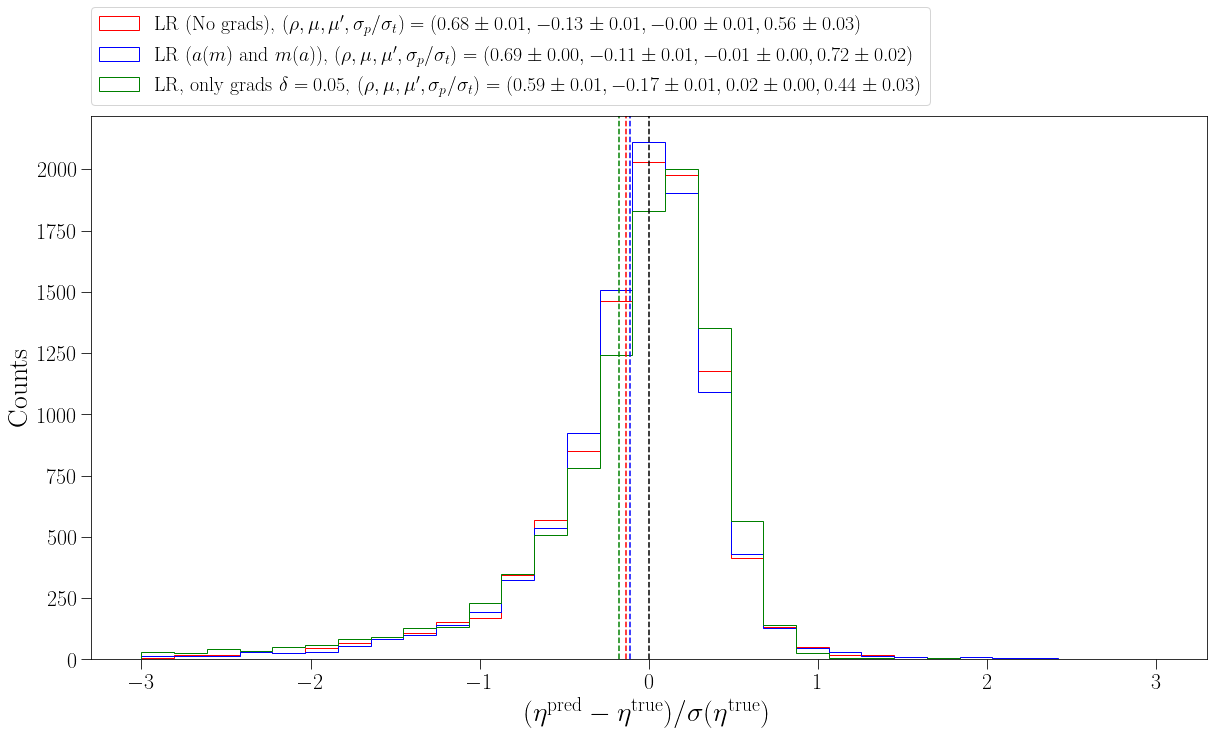

In [35]:
test_data = {'linear_no_grads': (am_test, r"\rm LR (No grads)", 'r'), 
             'linear_mam': (test_features_mam, r"\rm LR ($a(m)$ and $m(a)$)", 'b'),
            'linear_only_grads': (gamma_k_test[11], r"\rm LR, only grads $\delta=0.05$", 'g')}
combined_histogram(test_data, eta_test, eta_models, latex_var=r'\eta', n_bins=31, xrange=(-3, 3), figsize=(20, 10), 
                  calc_errs=True, cat_test=cat_test)

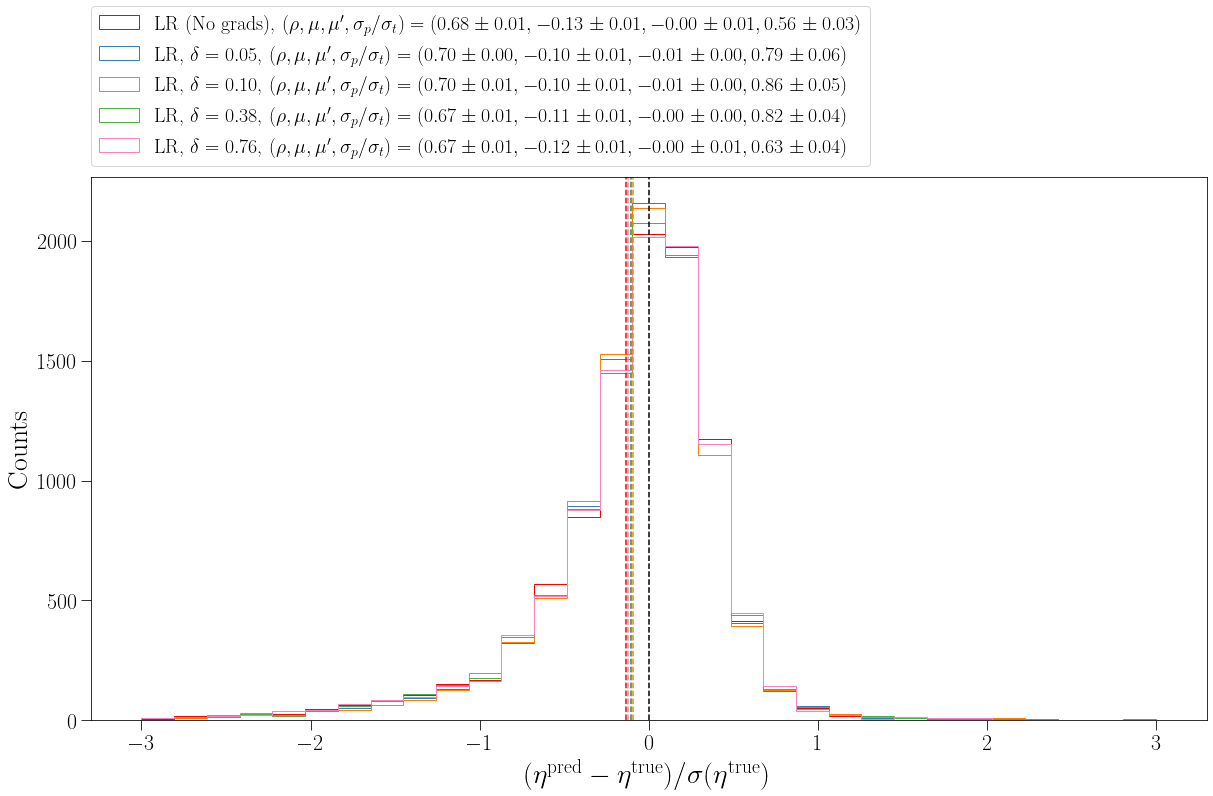

In [36]:
sg_test_data = {f'linear_sg_{k}':(test_features_k[k], 
                                  f'\\rm LR, $\delta={delta_k[k]:.2f}$', 
                                  colors[i]) for (i,k) in enumerate([11, 21, 81, 161])}
test_data = {'linear_no_grads': (am_test, r"\rm LR (No grads)", 'r'), **sg_test_data}
combined_histogram(test_data, eta_test, eta_models, latex_var=r'\eta', n_bins=31, xrange=(-3, 3), figsize=(20, 10), 
                  calc_errs=True, cat_test=cat_test)

## c_vir

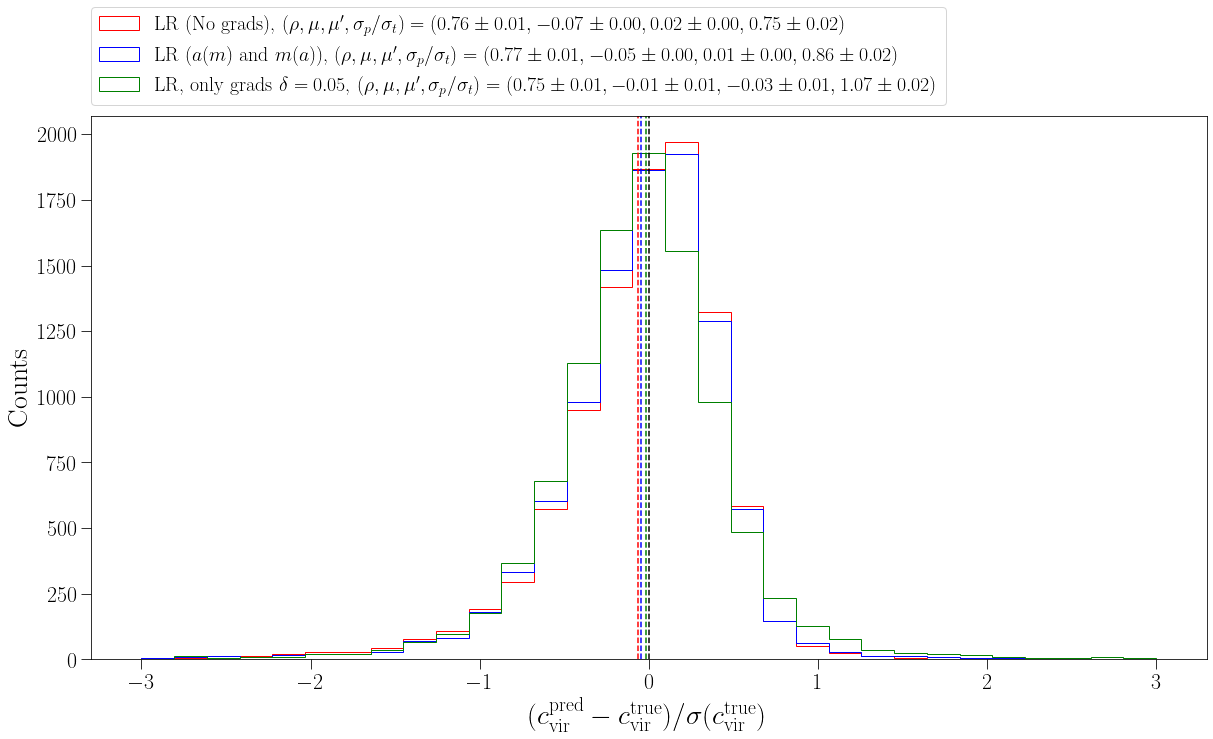

In [37]:
test_data = {'linear_no_grads': (am_test, r"\rm LR (No grads)", 'r'), 
             'linear_mam': (test_features_mam, r"\rm LR ($a(m)$ and $m(a)$)", 'b'),
            'linear_only_grads': (gamma_k_test[11], r"\rm LR, only grads $\delta=0.05$", 'g')}
combined_histogram(test_data, cvir_test, cvir_models, latex_var=r'c_{\rm vir}', n_bins=31, xrange=(-3, 3), 
                   figsize=(20, 10), cat_test=cat_test, calc_errs=True)

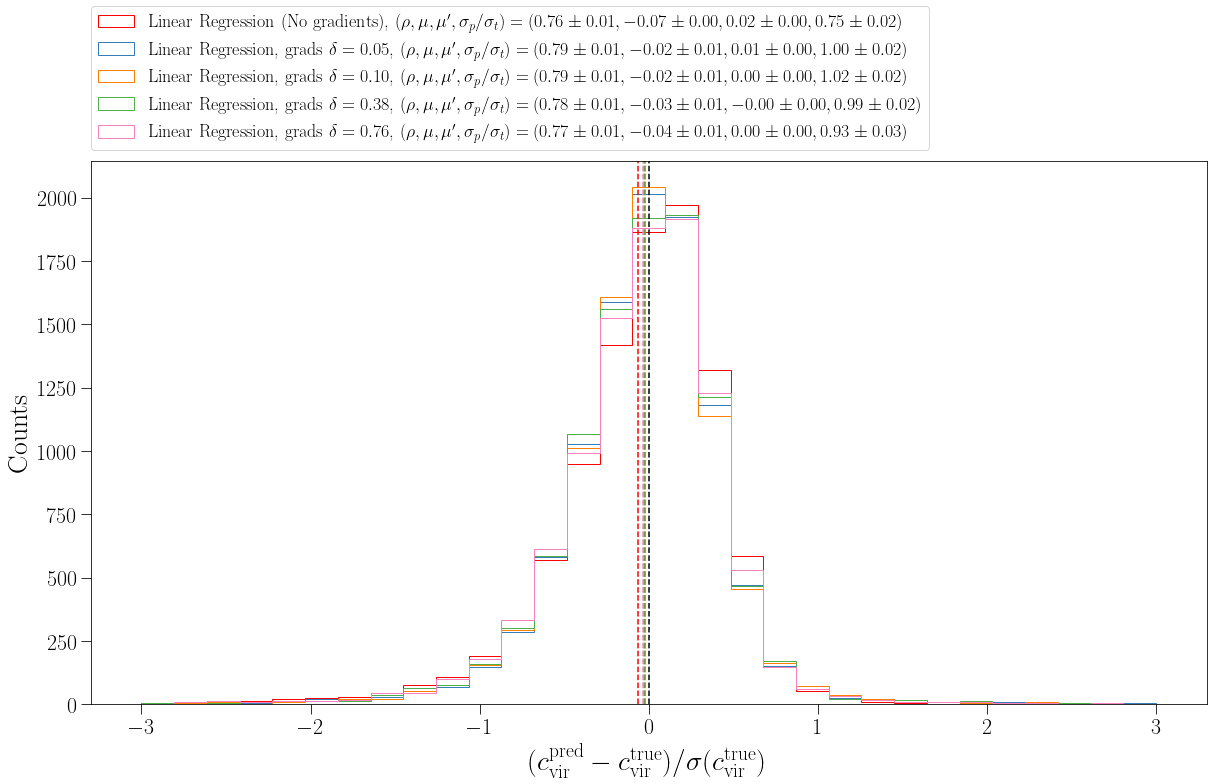

In [38]:
sg_test_data = {f'linear_sg_{k}':(test_features_k[k], 
                                  f'\\rm Linear Regression, grads $\delta={delta_k[k]:.2f}$', 
                                  colors[i]) for (i,k) in enumerate([11, 21, 81, 161])}
test_data = {'linear_no_grads': (am_test, r"\rm Linear Regression (No gradients)", 'r'), **sg_test_data}
combined_histogram(test_data, cvir_test, cvir_models, latex_var=r'c_{\rm vir}', n_bins=31, 
                   xrange=(-3, 3), figsize=(20, 10), legend_size=18, calc_errs=True, cat_test=cat_test)